In [1]:
import xnemogcm
import xgcm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from matplotlib.colors import LogNorm
import gsw
import cmocean.cm as cmo
import xarray as xr
import cmasher as cmr
import matplotlib.colors as mcolors
xr.set_options(keep_attrs=True)
plt.rcParams['font.size']=14

In [2]:
n_lev=16
col = cmr.take_cmap_colors(cmo.thermal, n_lev, return_fmt='hex')

col[-1]='#faf0e6'
colors_halo=mcolors.LinearSegmentedColormap.from_list('colormap', col)
print(len(col))

16


# Compare to GLORYS12

In [64]:
# path to the stored data
path12=('../../MAUD_RISE_config/maud_v4/g12/')
# load Glorys12 fields , use compat override, since the time in the time dimension changes after 2018, but this data is not used anyways
dsha_g12=xr.open_mfdataset(path12+'[T,S,M]*_ha_g12.nc',compat='override')
dstc_g12=xr.open_mfdataset(path12+'[T,S,M]*_tc_g12.nc',compat='override')
time_arrayg12=np.array(dstc_g12.time_counter,dtype=np.datetime64)
#vectorg12=np.zeros(len(time_arrayg12))-70

In [89]:
dsha_g12['sig0_ha12']=gsw.sigma0(dsha_g12.vosaline,dsha_g12.votemper)
dstc_g12['sig0_tc12']=gsw.sigma0(dstc_g12.vosaline,dstc_g12.votemper)

# Maud36

In [66]:
# path to the stored data
path36=('../../MAUD_RISE_config/maud_v4/m36_ke2/rev_data/')

dsha36=xr.open_mfdataset(path36+'[T,S,M,N]*_ha*_m36.nc')
dsic36=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_ke2/si*_m36.nc')
del dsic36['sig0_l2']
dstc36=xr.open_mfdataset(path36+'[T,S,M,N]*_tc*_m36.nc')
# load domain for computing the depth
dep36=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_mask/1_domain_cfg_50levels_new.nc')
deptht=dep36.e3t_1d.cumsum(dim='z')- 0.5*dep36.e3t_1d.isel(z=0)
depthw=dep36.e3w_1d.cumsum(dim='z')- 0.5*dep36.e3w_1d.isel(z=0)
deptht=deptht.swap_dims({'z':'z_c'})
deptht=deptht.rename("deptht")
depthw=depthw.swap_dims({'z':'z_f'})
depthw=depthw.rename("depthw")
# load masks for averaging sea ice fields
mask=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_mask/mask*.nc')

In [16]:
sic_tc=dsic36.siconc.where(mask.mask_tc==1).mean(dim={'x_c','y_c'})
sic_ha=dsic36.siconc.where(mask.mask_ha_mod==1).mean(dim={'x_c','y_c'})
sic_tc.load()
sic_ha.load()

In [101]:
dsha36.coords['depth']=deptht
dstc36.coords['depth']=deptht
dsha36.coords['depthw']=depthw
dstc36.coords['depthw']=depthw
dsha36.coords['month']=dsha36.t.dt.month
dsha36.coords['year']=dsha36.t.dt.year
dsha36.coords['day']=dsha36.t.dt.day
time_array36=np.array(dsha36.t,dtype=np.datetime64)
# compute sigma0
dsha36['sig0_ha36']=gsw.sigma0(dsha36.S_mean_ha,dsha36.T_mean_ha)
dstc36['sig0_tc36']=gsw.sigma0(dstc36.S_mean_tc,dstc36.T_mean_tc)


In [102]:
dsha36

<xarray.Dataset>
Dimensions:      (t: 4016, z_c: 50, z_f: 50)
Coordinates:
  * t            (t) datetime64[ns] 2007-01-01T12:00:00 ... 2017-12-31T12:00:00
  * z_f          (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 44.5 45.5 46.5 47.5 48.5
  * z_c          (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    depth        (z_c) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    depthw       (z_f) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    month        (t) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
    year         (t) int64 2007 2007 2007 2007 2007 ... 2017 2017 2017 2017 2017
    day          (t) int64 1 2 3 4 5 6 7 8 9 10 ... 23 24 25 26 27 28 29 30 31
Data variables:
    MLD_mean_ha  (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    N2_mean_ha   (t, z_f) float32 dask.array<chunksize=(365, 50), meta=np.ndarray>
    S_mean_ha    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    T_mean_ha    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    sig0_ha36    (t, z_c) float64 dask.array<chunksize=(31, 50), meta=np.ndarray>

In [131]:
mon1st=np.where(dsha36.day==1)[0]
mon1st

array([   0,   31,   59,   90,  120,  151,  181,  212,  243,  273,  304,
        334,  365,  396,  425,  456,  486,  517,  547,  578,  609,  639,
        670,  700,  731,  762,  790,  821,  850,  881,  911,  942,  973,
       1003, 1034, 1064, 1095, 1126, 1154, 1185, 1215, 1246, 1275, 1306,
       1337, 1367, 1398, 1428, 1459, 1490, 1518, 1549, 1579, 1610, 1640,
       1671, 1702, 1732, 1763, 1793, 1824, 1855, 1884, 1915, 1945, 1976,
       2006, 2037, 2068, 2098, 2129, 2159, 2190, 2221, 2249, 2280, 2310,
       2341, 2371, 2402, 2433, 2463, 2494, 2524, 2555, 2586, 2614, 2645,
       2675, 2706, 2736, 2767, 2798, 2828, 2859, 2889, 2920, 2951, 2979,
       3010, 3040, 3071, 3101, 3132, 3163, 3193, 3224, 3254, 3285, 3316,
       3345, 3376, 3406, 3437, 3467, 3498, 3529, 3559, 3590, 3620, 3651,
       3682, 3710, 3741, 3771, 3802, 3832, 3863, 3894, 3924, 3955, 3985])

In [132]:
mon1st[0]

0

In [147]:
tmon_ticks=np.zeros(len(mon1st))
for i in range(0,len(mon1st)):
    tmon_ticks[i]=dsha36.t.isel(t=mon1st[i])

In [148]:
tmon_ticks

array([1.1676528e+18, 1.1703312e+18, 1.1727504e+18, 1.1754288e+18,
       1.1780208e+18, 1.1806992e+18, 1.1832912e+18, 1.1859696e+18,
       1.1886480e+18, 1.1912400e+18, 1.1939184e+18, 1.1965104e+18,
       1.1991888e+18, 1.2018672e+18, 1.2043728e+18, 1.2070512e+18,
       1.2096432e+18, 1.2123216e+18, 1.2149136e+18, 1.2175920e+18,
       1.2202704e+18, 1.2228624e+18, 1.2255408e+18, 1.2281328e+18,
       1.2308112e+18, 1.2334896e+18, 1.2359088e+18, 1.2385872e+18,
       1.2411792e+18, 1.2438576e+18, 1.2464496e+18, 1.2491280e+18,
       1.2518064e+18, 1.2543984e+18, 1.2570768e+18, 1.2596688e+18,
       1.2623472e+18, 1.2650256e+18, 1.2674448e+18, 1.2701232e+18,
       1.2727152e+18, 1.2753936e+18, 1.2779856e+18, 1.2806640e+18,
       1.2833424e+18, 1.2859344e+18, 1.2886128e+18, 1.2912048e+18,
       1.2938832e+18, 1.2965616e+18, 1.2989808e+18, 1.3016592e+18,
       1.3042512e+18, 1.3069296e+18, 1.3095216e+18, 1.3122000e+18,
       1.3148784e+18, 1.3174704e+18, 1.3201488e+18, 1.3227408e

In [162]:
dsha36

<xarray.Dataset>
Dimensions:      (t: 4016, z_c: 50, z_f: 50)
Coordinates:
  * t            (t) datetime64[ns] 2007-01-01T12:00:00 ... 2017-12-31T12:00:00
  * z_f          (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 44.5 45.5 46.5 47.5 48.5
  * z_c          (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    depth        (z_c) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    depthw       (z_f) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    month        (t) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
    year         (t) int64 2007 2007 2007 2007 2007 ... 2017 2017 2017 2017 2017
    day          (t) int64 1 2 3 4 5 6 7 8 9 10 ... 23 24 25 26 27 28 29 30 31
Data variables:
    MLD_mean_ha  (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    N2_mean_ha   (t, z_f) float32 dask.array<chunksize=(365, 50), meta=np.ndarray>
    S_mean_ha    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    T_mean_ha    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    sig0_ha36    (t, z_c) float64 dask.array<chunksize=(31, 50), meta=np.ndarray>

In [155]:
year1st=np.where((dsha36.day==1)&(dsha36.month==1))[0].astype(int)
year1st

array([   0,  365,  731, 1095, 1459, 1824, 2190, 2555, 2920, 3285, 3651])

In [156]:
dsha36.year[year1st]

<xarray.DataArray 'year' (t: 11)>
array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])
Coordinates:
  * t        (t) datetime64[ns] 2007-01-01T12:00:00 ... 2017-01-01T12:00:00
    month    (t) int64 1 1 1 1 1 1 1 1 1 1 1
    year     (t) int64 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
    day      (t) int64 1 1 1 1 1 1 1 1 1 1 1

In [172]:
import datetime

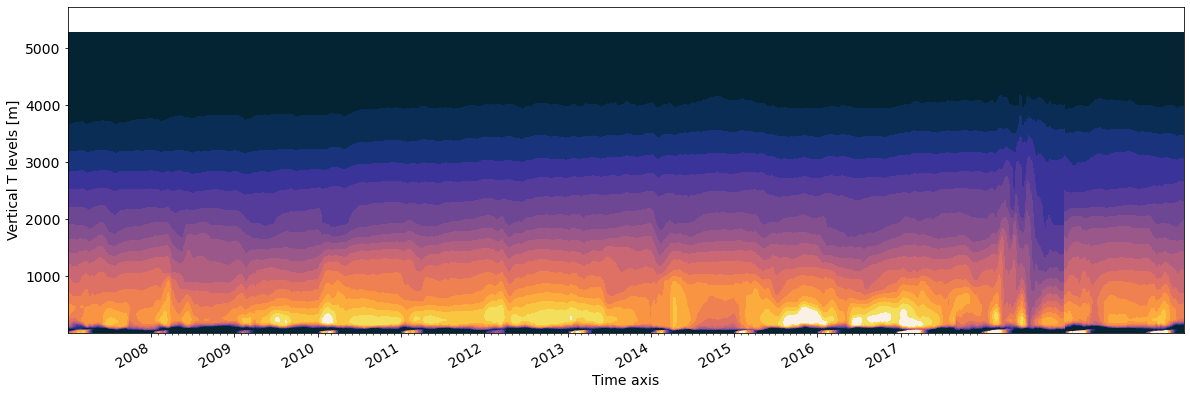

In [187]:
fig,axes=plt.subplots(1,1,figsize=(20,6))
ax=axes
ct1=dsha_g12.votemper.plot.contourf(x='time_counter',y='deptht',ax=axes,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)
years = np.arange(2008,2018)
ax.set_xticks([datetime.datetime(i,1,1) for i in years])#,dsha36.year[year1st])
ax.set_xticklabels(years)

minor_ticks = []
for y in years:
    minor_ticks += [datetime.datetime(y,m,1) for m in range(1,13)]
ax.set_xticks(minor_ticks, minor=True);

In [171]:
ax.get_xticks()

array([   0., 1000., 2000., 3000., 4000., 5000.])

<ipython-input-110-e9799452643f>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
<ipython-input-110-e9799452643f>:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])


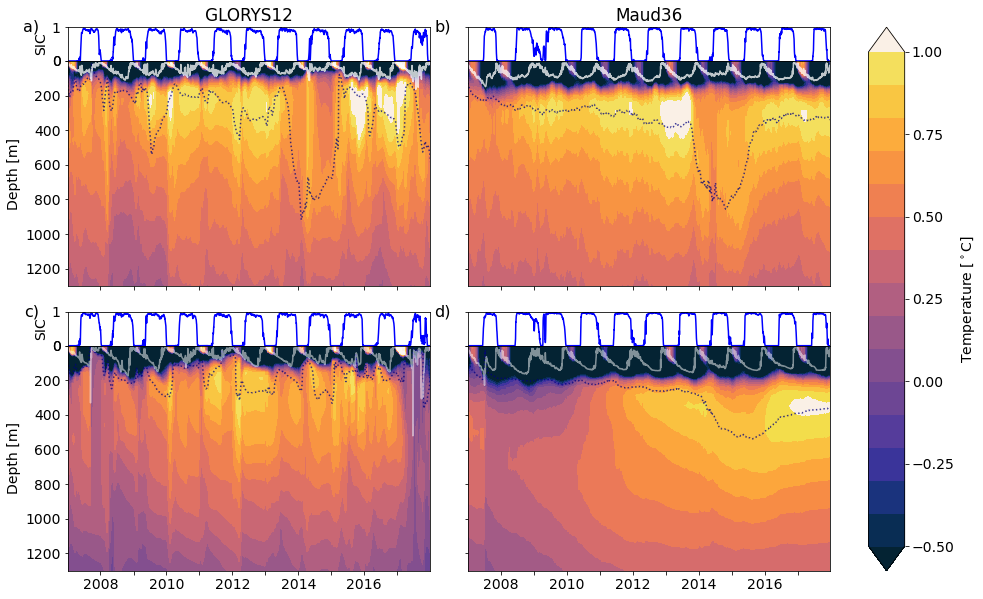

In [110]:
#Figure 6 of the manuscript
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec


fig = plt.figure(figsize=(15,10))
gs = GridSpec(2,3, width_ratios=[1,1,0.1],wspace=.15,hspace=.1)#,wspace=0.3)

gs1 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0,0],hspace=0, height_ratios=[.15,1])
gs2 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,0],hspace=0, height_ratios=[.15,1])
gs3 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0,1],hspace=0, height_ratios=[.15,1])
gs4 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,1],hspace=0, height_ratios=[.15,1])


#ttc_g12 = fig.add_subplot(gs2[1])#,sharey=ttc_m12)
sha_g12 = fig.add_subplot(gs1[0],sharex=ttc_g12,xticklabels=[])
tha_g12 = fig.add_subplot(gs1[1],sharex=ttc_g12,xticklabels=[])
stc_g12 = fig.add_subplot(gs2[0],sharex=ttc_g12,xticklabels=[])
ttc_g12 = fig.add_subplot(gs2[1])#,sharey=ttc_m12)
#ttc_m36 = fig.add_subplot(gs4[1])#,sharey=ttc_g12)
sha_m36 = fig.add_subplot(gs3[0],sharex=ttc_m36,xticklabels=[])#,sharey=sha_g12)
tha_m36 = fig.add_subplot(gs3[1],sharex=ttc_m36,xticklabels=[])#,sharey=tha_g12)
stc_m36 = fig.add_subplot(gs4[0],sharex=ttc_m36,xticklabels=[])#,sharey=stc_g12)
ttc_m36 = fig.add_subplot(gs4[1])#,sharey=ttc_g12)

c_ax=fig.add_subplot(gs[:,2])


ax=sha_g12
dsha_g12.ileadfra.plot(x="time_counter",ax=ax,color='b')
ax.set_ylabel('SIC')
ax.set_xlabel('')
ax.set_title('') 
ax.set_ylim(0,1)
ax.set_xticklabels('')
plt.text(-0.1, 1, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
ax=tha_g12
ct1=dsha_g12.votemper.plot.contourf(x='time_counter',y='deptht',ax=ax,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)
c1=dsha_g12.sig0_ha12.plot.contour(x='time_counter',y='deptht',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dsha_g12.somxl010.plot(x="time_counter",ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')
ax.set_title('') 

ax.set_xticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))


ax=stc_g12
dstc_g12.ileadfra.plot(x="time_counter",ax=ax,color='b')
ax.set_ylabel('SIC')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels('')
ax.set_ylim(0,1)
plt.text(-0.1, 1, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
ax=ttc_g12
dstc_g12.votemper.plot.contourf(x='time_counter',y='deptht',ax=ax,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=dstc_g12.sig0_tc12.plot.contour(x='time_counter',y='deptht',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dstc_g12.somxl010.plot(x="time_counter",ax=ax,color='w',alpha=.5)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')
ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
ax.set_title('') 
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)

# Maud36
ax=sha_m36
sic_ha.plot(x="t",ax=ax,color='b')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylim(0,1)
plt.text(-0.07, 1, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
ax=tha_m36
ct1=dsha36.T_mean_ha.plot.contourf(x='t',y='depth',ax=ax,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)
c1=dsha36.sig0_ha36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dsha36.MLD_mean_ha.plot(x='t',ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))

ax=stc_m36
sic_tc.plot(x="t",ax=ax,color='b')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.set_ylim(0,1)
plt.text(-0.07, 1, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
ax=ttc_m36
dstc36.T_mean_tc.plot.contourf(x='t',y='depth',ax=ax,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=dstc36.sig0_tc36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dstc36.MLD_mean_tc.plot(x='t',ax=ax,color='w',alpha=.5)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-1]))

sha_g12.set_title('GLORYS12')
sha_m36.set_title('Maud36')
plt.colorbar(ct1,cax=c_ax,orientation="vertical",label='Temperature [$^\circ$C]',ticks=np.arange(-.5,1.25,0.25))

#plt.savefig('./T_sic_hatc_g12_m36.jpg',dpi=300)




<ipython-input-98-cf387efeb33e>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
<ipython-input-98-cf387efeb33e>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])


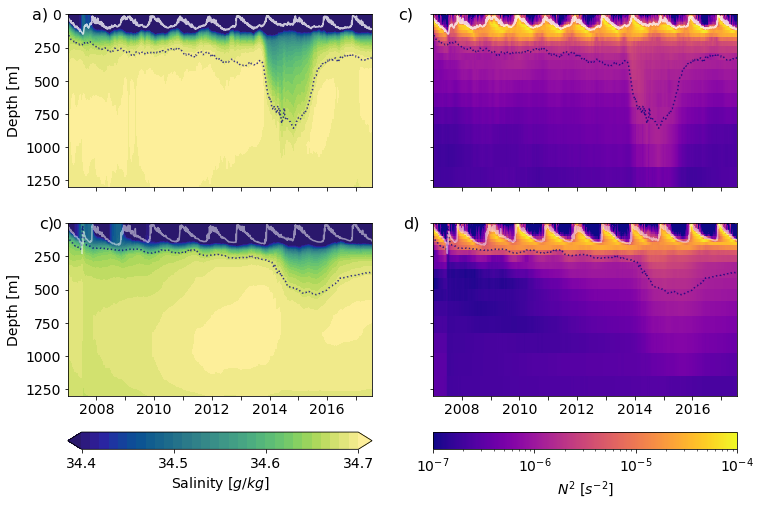

In [98]:
fig,axes=plt.subplots(3,2,figsize=(12,8),gridspec_kw={'height_ratios':[1,1,0.1],'hspace':.3})
ax=axes[0,0]
cs1=dsha36.S_mean_ha.plot.contourf(x='t',y='depth',ax=ax,cmap=cmo.haline,vmin=34.4,vmax=34.7,levels=31,add_colorbar=False)
c1=dsha36.sig0_ha36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dsha36.MLD_mean_ha.plot(x="t",ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels('')
#ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))
plt.text(-0.09, 1, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
ax=axes[1,0]
dstc36.S_mean_tc.plot.contourf(x='t',y='depth',ax=ax,cmap=cmo.haline,vmin=34.4,vmax=34.7,levels=31,add_colorbar=False)#,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=dstc36.sig0_tc36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dstc36.MLD_mean_tc.plot(x="t",ax=ax,color='w',alpha=.5)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
#ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))
plt.colorbar(cs1,cax=axes[2,0],orientation="horizontal",label='Salinity [$g/kg$]',ticks=np.arange(34.4,34.8,0.1))
plt.text(-0.07, 1, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')


ax=axes[0,1]
cn1=dsha36.N2_mean_ha.plot.pcolormesh(x='t',y='depthw',ax=ax,norm=LogNorm(vmin=1e-7,vmax=1e-4),cmap='plasma',add_colorbar=False)
c1=dsha36.sig0_ha36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dsha36.MLD_mean_ha.plot(x="t",ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))
plt.text(-0.09, 1, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')

ax=axes[1,1]
dstc36.N2_mean_tc.plot.pcolormesh(x='t',y='depthw',ax=ax,norm=LogNorm(vmin=1e-7,vmax=1e-4),cmap='plasma',add_colorbar=False)#,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=dstc36.sig0_tc36.plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
dstc36.MLD_mean_tc.plot(x="t",ax=ax,color='w',alpha=.5)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))
plt.colorbar(cn1,cax=axes[2,1],orientation="horizontal",label='$N^2$ [$s^{-2}$]')#,ticks=np.arange(34.4,34.9,0.1))
plt.text(-0.07, 1, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize='16')
plt.savefig('./S_N2_tc_ha_m36.jpg',dpi=300)

# SSH mean -Maud36

In [25]:
# path to the stored data
path36=('../../MAUD_RISE_config/maud_v4/m36_ke2/')

ds36=xr.open_mfdataset(path36+'ssh*_m36.nc')
bat=xr.open_dataset('../../MAUD_RISE_config/maud_v4/m36_mask/1_domain_cfg_50levels_new.nc')
bat.coords['nav_lon']=bat.nav_lon.mean(dim='y')
bat.coords['nav_lat']=bat.nav_lat.mean(dim='x')
bat=bat.swap_dims({'x':'x_c','y':'y_c'})
ds36=xr.merge((ds36,bat.bathy_meter))
sshmean=ds36.zos.mean(dim='t')
sshmean.load()

<xarray.Dataset>
Dimensions:      (t: 4016, x_c: 879, y_c: 804)
Coordinates:
  * x_c          (x_c) int64 0 1 2 3 4 5 6 7 ... 871 872 873 874 875 876 877 878
  * y_c          (y_c) int64 0 1 2 3 4 5 6 7 ... 796 797 798 799 800 801 802 803
  * t            (t) datetime64[ns] 2007-01-01T12:00:00 ... 2017-12-31T12:00:00
    glamt        (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    gphit        (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    nav_lon      (x_c) float32 -5.111 -5.0 -4.972 -4.944 ... 19.31 19.33 19.36
    nav_lat      (y_c) float32 -70.54 -70.5 -70.49 ... -61.58 -61.57 -61.55
Data variables:
    zos          (t, y_c, x_c) float32 dask.array<chunksize=(31, 804, 879), meta=np.ndarray>
    bathy_meter  (y_c, x_c) float32 ...

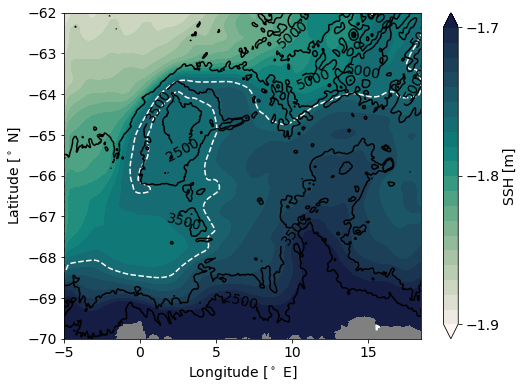

In [32]:
# Figure 7 of the manuscript
fig,axes=plt.subplots(1,1,figsize=(8,6),sharey=True)
ax=axes
sshmean.plot.contourf(x="glamt",y="gphit",vmin=-1.9,vmax=-1.7,levels=21,cmap=cmo.tempo,
                                                      cbar_kwargs={'label':'SSH [m]','ticks':np.arange(-1.9,-1.6,0.1)})
sshmean.plot.contour(x="glamt",y="gphit",levels=[-1.76],colors='w')
c=ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='k',alpha=1)
ds36.bathy_meter.where(ds36.bathy_meter<2).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlabel('Longitude [$^\circ$ E]')
ax.set_ylabel('Latitude [$^\circ$ N]')
ax.clabel(c,fmt='%d')
ax.set_xlim(-5,18.5)
ax.set_ylim(-70,-62)
plt.savefig('../figures/SSHmean_m36.jpg',dpi=300)